# Preparetion:

Install extra libraries:

In [ ]:
!pip install gdown
!pip install jsonlines

Import Necessary Libraries:

In [2]:
import torch.nn as nn
import torch
from transformers import BertModel, BertTokenizer
import random
import numpy as np
import gdown
# from transformers import *
from torch.utils.data import Dataset, DataLoader
import jsonlines
import torch.nn.functional as F
import matplotlib.pyplot as plt

Set Device & Randomness:

In [3]:
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
if torch.cuda.is_available():
  torch.cuda.manual_seed_all(seed_val)

# If there's a GPU available...
if torch.cuda.is_available():
    # Tell PyTorch to use the GPU.
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


Define Classes:

Here we define a class for discriminator and dataset. Also, we implement two different generator class.

In [4]:
class CustomDataset(Dataset):
    def __init__(self, jsonl_file_path, tokenizer, max_length=128):
        self.samples = []
        self.tokenizer = tokenizer
        self.max_length = max_length

        with jsonlines.open(jsonl_file_path, 'r') as reader:
            for obj in reader:
                self.samples.append(obj)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        txt = self.samples[idx]['text']
        encoding = self.tokenizer(txt, truncation=True, padding='max_length', max_length=self.max_length, return_tensors='pt')

        return {
            'id': self.samples[idx]['id'],
            'label': self.samples[idx]['label'],
            'text': self.samples[idx]['text'],
            'model': self.samples[idx]['model'],
            'source': self.samples[idx]['source'],
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze(),
        }


class G1(nn.Module):
    def __init__(self, noise_size=100, hidden_size=768, output_size=768, dropout_rate=0.2):
        super(G1, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(noise_size, hidden_size),
            nn.LeakyReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_size, output_size)
        )
    def forward(self, noise):
        return self.layers(noise)


class G2(nn.Module):
    def __init__(self, bert_model_name='bert-base-cased'):
        super(G2, self).__init__()
        # Initialize the BERT tokenizer and model
        self.tokenizer = BertTokenizer.from_pretrained(bert_model_name)
        self.bert = BertModel.from_pretrained(bert_model_name)
        for param in self.bert.parameters():
            param.requires_grad = True

    def forward(self, rBoW):
        # inputs = self.tokenizer(rBoW, return_tensors='pt', padding=True, truncation=True)
        outputs = self.bert(**rBoW)
        pooler_output = outputs.pooler_output
        return pooler_output

class Discriminator(nn.Module):
    def __init__(self, dropout_rate_input=0.2, dropout_rate_hidden=0.4, input_size=768, hidden_size=768, num_classes=6):
        super(Discriminator, self).__init__()
        self.do1 = nn.Dropout(dropout_rate_input)
        self.l1 = nn.Linear(input_size, hidden_size)
        self.act1 = nn.LeakyReLU()
        self.do2 = nn.Dropout(dropout_rate_hidden)
        self.l2 = nn.Linear(hidden_size, num_classes+1)
        self.sm = nn.Softmax(dim=1)

    def forward(self, Vg):
        do1_out = self.do1(Vg)
        l1_out =  self.act1(self.l1(do1_out))
        do2_out = self.do2(l1_out)
        l2_out = self.l2(do2_out)
        probs = self.sm(l2_out)

        return l1_out, probs, l2_out


Download Dataset and Prepare Dataloaders:

In [5]:
# Google Drive folder URL and folder ID
url = 'https://drive.google.com/drive/folders/11YeloR2eTXcTzdwI04Z-M2QVvIeQAU6-'
folder_id = '11YeloR2eTXcTzdwI04Z-M2QVvIeQAU6-'

# Create the destination folder
!mkdir dataset_folder

# Download the folder using gdown
gdown.download_folder(id=folder_id, output='dataset_folder', quiet=False, use_cookies=False)


# Path to your JSONL file
# jsonl_train_path = '/kaggle/working/dataset_folder/subtaskB_train.jsonl'
# jsonl_dev_path = '/kaggle/working/dataset_folder/subtaskB_dev.jsonl'
jsonl_train_path = '/content/dataset_folder/subtaskB_train.jsonl'
jsonl_dev_path = '/content/dataset_folder/subtaskB_dev.jsonl'

Retrieving folder contents


Processing file 1oh9c-d0fo3NtETNySmCNLUc6H1j4dSWE subtaskB_dev.jsonl
Processing file 1k5LMwmYF7PF-BzYQNE2ULBae79nbM268 subtaskB_train.jsonl
Building directory structure completed


Retrieving folder contents completed
Building directory structure
Downloading...
From: https://drive.google.com/uc?id=1oh9c-d0fo3NtETNySmCNLUc6H1j4dSWE
To: /content/dataset_folder/subtaskB_dev.jsonl
100%|██████████| 4.93M/4.93M [00:00<00:00, 40.3MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1k5LMwmYF7PF-BzYQNE2ULBae79nbM268
From (redirected): https://drive.google.com/uc?id=1k5LMwmYF7PF-BzYQNE2ULBae79nbM268&confirm=t&uuid=534204bf-a263-44c2-8571-fae2e22432e3
To: /content/dataset_folder/subtaskB_train.jsonl
100%|██████████| 155M/155M [00:01<00:00, 118MB/s]
Download completed


# Generator1 Results:

Define GAN Neccessary Objects:

In [6]:
model_name = "bert-base-cased"
generator1 = G1()
discriminator = Discriminator()

# Load pre-trained BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained(model_name)
bert_model = BertModel.from_pretrained(model_name)

# Move to GPU
if torch.cuda.is_available():
  generator1.cuda()
  discriminator.cuda()
  bert_model.cuda()

# Create an instance of your custom dataset
train_dataset = CustomDataset(jsonl_train_path, tokenizer, max_length=512)
dev_dataset = CustomDataset(jsonl_dev_path, tokenizer, max_length=512)

# Create a DataLoader
batch_size_train = 16
batch_size_dev = 16
dataloader_train = DataLoader(train_dataset, batch_size=batch_size_train, shuffle=True)
dataloader_dev = DataLoader(dev_dataset, batch_size=batch_size_dev, shuffle=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Train Loop(Annotation=50%):

In [ ]:
#models parameters
d_vars = [v for v in discriminator.parameters()]
g_vars = [v for v in generator1.parameters()]
bert_vars = [i for i in bert_model.parameters()]
d_vars = bert_vars + d_vars

#optimizer
dis_optimizer = torch.optim.AdamW(d_vars, lr=5e-6)
gen_optimizer = torch.optim.AdamW(g_vars, lr=5e-6)
bert_optimizer = torch.optim.AdamW(bert_vars, lr=5e-6)


num_train_epochs = 1
epsilon = 1e-8
training_stats = []
percentage_dataset = 10
d_loss_hist = [[], [], []]


for epoch_i in range(0, num_train_epochs):
    # Perform one full pass over the training set.
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, num_train_epochs))
    print('Training...')

    # Reset the total loss for this epoch.
    tr_g_loss = 0
    tr_d_loss = 0

    # Put the model into training mode.
    bert_model.train()
    generator1.train()
    discriminator.train()

    # For each batch of training data...
    for step, batch in enumerate(dataloader_train):
        # if step*batch_size_train > len(dataloader_train)*percentage_dataset:
        #   break
        b_input_id = batch['id'].to(device)
        b_input_label = batch['label'].to(device)
        b_input_ids = batch['input_ids'].to(device)
        b_input_AM = batch['attention_mask'].to(device)

        outputs = bert_model(input_ids=b_input_ids, attention_mask=b_input_AM)
        pooler_output = outputs.pooler_output  # Get pooler output

        real_batch_size = b_input_ids.shape[0]

        fake_batch_size = real_batch_size
        noise = torch.randn(fake_batch_size, 100, device=device)

        gen_rep = generator1(noise)


        disciminator_input = torch.cat([pooler_output, gen_rep], dim=0)

        features, probs, logits = discriminator(disciminator_input)

        # Finally, we separate the discriminator's output for the real and fake
        features_list = torch.split(features, real_batch_size)
        real_features = features_list[0]
        fake_features = features_list[1]

        probs_list = torch.split(probs, real_batch_size)
        real_probs = probs_list[0]
        fake_probs = probs_list[1]

        logits_list = torch.split(logits, real_batch_size)
        real_logits = probs_list[0]
        fake_logits = probs_list[1]
        #---------------------------------
        #  LOSS evaluation
        #---------------------------------
        # Generator's LOSS estimation
        g_loss_d = -1 * torch.mean(torch.log(1 - fake_probs[:,-1] + epsilon))
        g_feat_reg = torch.mean(torch.pow(torch.mean(real_features, dim=0) - torch.mean(fake_features, dim=0), 2))
        beta = 1
        g_loss = (2-beta)*g_loss_d + beta*g_feat_reg



        # Disciminator's LOSS estimation
        logits = real_logits[:,0:-1]
        log_probs = F.log_softmax(logits, dim=-1)
        # The discriminator provides an output for labeled and unlabeled real data
        # so the loss evaluated for unlabeled data is ignored (masked)
        label2one_hot = torch.nn.functional.one_hot(b_input_label, 6)
        per_example_loss = -torch.sum(label2one_hot * log_probs, dim=-1)
        # -------- Mask Generation----------
        num_elements_annotated = 8
        anotated_percent = num_elements_annotated / batch_size_train # 1/64 ~= 1.56
        mask = torch.zeros_like(per_example_loss, dtype=torch.bool, device=device)
        indices_to_mask = torch.randperm(len(per_example_loss))[:num_elements_annotated].to(device)
        mask[indices_to_mask] = True
        # mask input
        per_example_loss = torch.masked_select(per_example_loss, mask)
        labeled_example_count = per_example_loss.type(torch.float32).numel()
        # supervised loss of discriminator
        D_L_Supervised = torch.div(torch.sum(per_example_loss.to(device)), labeled_example_count)
        # unsupervised loss of discriminator
        D_L_unsupervised1U = -1 * torch.mean(torch.log(1 - real_probs[:, -1] + epsilon))
        D_L_unsupervised2U = -1 * torch.mean(torch.log(fake_probs[:, -1] + epsilon))
        d_loss = D_L_Supervised + D_L_unsupervised1U + D_L_unsupervised2U



        d_loss_hist[0].append(D_L_Supervised.item())
        d_loss_hist[1].append(D_L_unsupervised1U.item())
        d_loss_hist[2].append(D_L_unsupervised2U.item())
        #---------------------------------
        #  OPTIMIZATION
        #---------------------------------
        gen_optimizer.zero_grad()
        dis_optimizer.zero_grad()
        bert_optimizer.zero_grad()


        # Calculate weigth updates
        # retain_graph=True is required since the underlying graph will be deleted after backward
        g_loss.backward(retain_graph=True)
        d_loss.backward()


        # Apply modifications
        gen_optimizer.step()
        dis_optimizer.step()


        # Save the losses to print them later
        tr_g_loss += g_loss.item()
        tr_d_loss += d_loss.item()


    # Calculate the average loss over all of the batches.
    avg_train_loss_g = tr_g_loss / len(dataloader_train)
    avg_train_loss_d = tr_d_loss / len(dataloader_train)


    print("  Average training loss generetor: {0:.3f}".format(avg_train_loss_g))
    print("  Average training loss discriminator: {0:.3f}".format(avg_train_loss_d))

    # ========================================
    #     TEST ON THE EVALUATION DATASET
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our test set.
    print("")
    print("Running Test...")

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    bert_model.eval() #maybe redundant
    discriminator.eval()
    generator1.eval()

    # Tracking variables
    total_test_accuracy = 0

    total_test_loss = 0
    nb_test_steps = 0

    all_preds = []
    all_labels_ids = []

    #loss
    nll_loss = torch.nn.CrossEntropyLoss(ignore_index=-1)


    # Evaluate data for one epoch
    for batch in dataloader_dev:
        # Unpack this training batch from our dataloader.
        b_input_id = batch['id'].to(device)
        b_input_label = batch['label'].to(device)
        b_input_ids = batch['input_ids'].to(device)
        b_input_AM = batch['attention_mask'].to(device)

        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():
            model_outputs = bert_model(b_input_ids, attention_mask=b_input_AM)
            pooler_output = model_outputs.pooler_output
            _, probs, logits = discriminator(pooler_output)
            ###log_probs = F.log_softmax(probs[:,1:], dim=-1)
            filtered_logits = logits[:,0:-1]
            # Accumulate the test loss.
            total_test_loss += nll_loss(filtered_logits, b_input_label)

        # Accumulate the predictions and the input labels
        _, preds = torch.max(filtered_logits, 1)
        all_preds += preds.detach().cpu()
        all_labels_ids += b_input_label.detach().cpu()

    # Report the final accuracy for this validation run.
    all_preds = torch.stack(all_preds).numpy()
    all_labels_ids = torch.stack(all_labels_ids).numpy()
    test_accuracy = np.sum(all_preds == all_labels_ids) / len(all_preds)
    print("  Accuracy: {0:.3f}".format(test_accuracy))

    # Calculate the average loss over all of the batches.
    avg_test_loss = total_test_loss / len(dataloader_dev)
    avg_test_loss = avg_test_loss.item()

    print("  Test Loss: {0:.3f}".format(avg_test_loss))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss generator': avg_train_loss_g,
            'Training Loss discriminator': avg_train_loss_d,
            'Valid. Loss': avg_test_loss,
            'Valid. Accur.': test_accuracy,
        }
    )




======== Epoch 1 / 1 ========

Training...

  Average training loss generetor: 0.705

  Average training loss discriminator: 2.177



Running Test...

  Accuracy: 0.569

  Test Loss: 2.264


Discriminator Loss

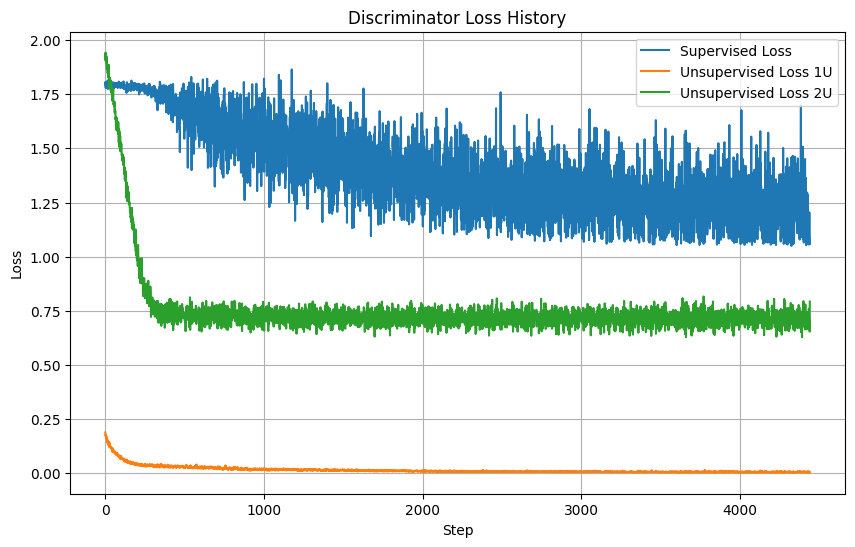

In [ ]:
# d_loss_hist contains three lists: D_L_Supervised, D_L_unsupervised1U, D_L_unsupervised2U
D_L_Supervised, D_L_unsupervised1U, D_L_unsupervised2U = d_loss_hist

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(D_L_Supervised, label='Supervised Loss')
plt.plot(D_L_unsupervised1U, label='Unsupervised Loss 1U')
plt.plot(D_L_unsupervised2U, label='Unsupervised Loss 2U')
plt.title('Discriminator Loss History')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

Annotation=12.5%



======== Epoch 1 / 1 ========

Training...


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.

  return self._call_impl(*args, **kwargs)


  Average training loss generetor: 0.701

  Average training loss discriminator: 2.336



Running Test...

  Accuracy: 0.448

  Test Loss: 2.093


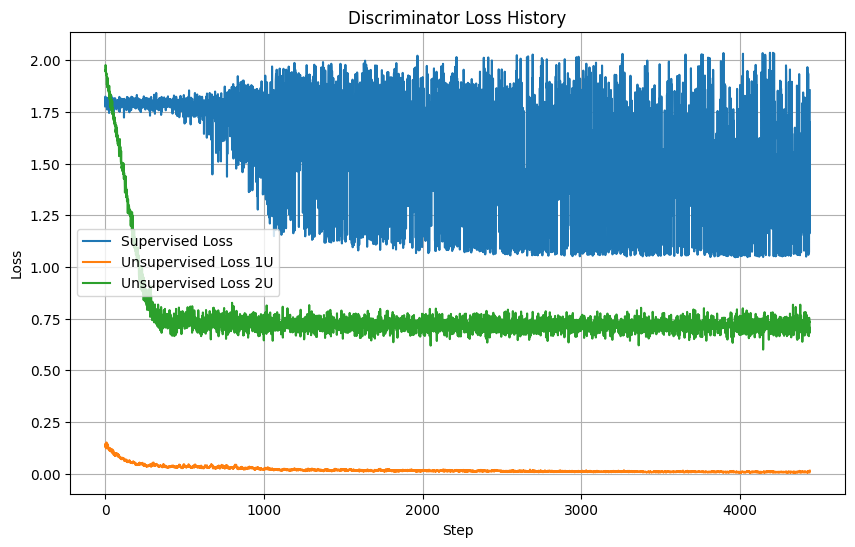

In [ ]:
model_name = "bert-base-cased"
generator1 = G1()
discriminator = Discriminator()

# Load pre-trained BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained(model_name)
bert_model = BertModel.from_pretrained(model_name)

# Move to GPU
if torch.cuda.is_available():
  generator1.cuda()
  discriminator.cuda()
  bert_model.cuda()

# Create an instance of your custom dataset
train_dataset = CustomDataset(jsonl_train_path, tokenizer, max_length=512)
dev_dataset = CustomDataset(jsonl_dev_path, tokenizer, max_length=512)

# Create a DataLoader
batch_size_train = 16
batch_size_dev = 16
dataloader_train = DataLoader(train_dataset, batch_size=batch_size_train, shuffle=True)
dataloader_dev = DataLoader(dev_dataset, batch_size=batch_size_dev, shuffle=True)


#-------------------------------------------------------------------------------
#models parameters
d_vars = [v for v in discriminator.parameters()]
g_vars = [v for v in generator1.parameters()]
bert_vars = [i for i in bert_model.parameters()]
d_vars = bert_vars + d_vars

#optimizer
dis_optimizer = torch.optim.AdamW(d_vars, lr=5e-6)
gen_optimizer = torch.optim.AdamW(g_vars, lr=5e-6)
bert_optimizer = torch.optim.AdamW(bert_vars, lr=5e-6)


num_train_epochs = 1
epsilon = 1e-8
training_stats = []
percentage_dataset = 10
d_loss_hist = [[], [], []]


for epoch_i in range(0, num_train_epochs):
    # Perform one full pass over the training set.
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, num_train_epochs))
    print('Training...')

    # Reset the total loss for this epoch.
    tr_g_loss = 0
    tr_d_loss = 0

    # Put the model into training mode.
    bert_model.train()
    generator1.train()
    discriminator.train()

    # For each batch of training data...
    for step, batch in enumerate(dataloader_train):
        # if step*batch_size_train > len(dataloader_train)*percentage_dataset:
        #   break
        b_input_id = batch['id'].to(device)
        b_input_label = batch['label'].to(device)
        b_input_ids = batch['input_ids'].to(device)
        b_input_AM = batch['attention_mask'].to(device)

        outputs = bert_model(input_ids=b_input_ids, attention_mask=b_input_AM)
        pooler_output = outputs.pooler_output  # Get pooler output

        real_batch_size = b_input_ids.shape[0]

        fake_batch_size = real_batch_size
        noise = torch.randn(fake_batch_size, 100, device=device)

        gen_rep = generator1(noise)


        disciminator_input = torch.cat([pooler_output, gen_rep], dim=0)

        features, probs, logits = discriminator(disciminator_input)

        # Finally, we separate the discriminator's output for the real and fake
        features_list = torch.split(features, real_batch_size)
        real_features = features_list[0]
        fake_features = features_list[1]

        probs_list = torch.split(probs, real_batch_size)
        real_probs = probs_list[0]
        fake_probs = probs_list[1]

        logits_list = torch.split(logits, real_batch_size)
        real_logits = probs_list[0]
        fake_logits = probs_list[1]
        #---------------------------------
        #  LOSS evaluation
        #---------------------------------
        # Generator's LOSS estimation
        g_loss_d = -1 * torch.mean(torch.log(1 - fake_probs[:,-1] + epsilon))
        g_feat_reg = torch.mean(torch.pow(torch.mean(real_features, dim=0) - torch.mean(fake_features, dim=0), 2))
        beta = 1
        g_loss = (2-beta)*g_loss_d + beta*g_feat_reg



        # Disciminator's LOSS estimation
        logits = real_logits[:,0:-1]
        log_probs = F.log_softmax(logits, dim=-1)
        # The discriminator provides an output for labeled and unlabeled real data
        # so the loss evaluated for unlabeled data is ignored (masked)
        label2one_hot = torch.nn.functional.one_hot(b_input_label, 6)
        per_example_loss = -torch.sum(label2one_hot * log_probs, dim=-1)
        # -------- Mask Generation----------
        num_elements_annotated = 2
        anotated_percent = num_elements_annotated / batch_size_train # 2/16 ~= 12.5
        mask = torch.zeros_like(per_example_loss, dtype=torch.bool, device=device)
        indices_to_mask = torch.randperm(len(per_example_loss))[:num_elements_annotated].to(device)
        mask[indices_to_mask] = True
        # mask input
        per_example_loss = torch.masked_select(per_example_loss, mask)
        labeled_example_count = per_example_loss.type(torch.float32).numel()
        # supervised loss of discriminator
        D_L_Supervised = torch.div(torch.sum(per_example_loss.to(device)), labeled_example_count)
        # unsupervised loss of discriminator
        D_L_unsupervised1U = -1 * torch.mean(torch.log(1 - real_probs[:, -1] + epsilon))
        D_L_unsupervised2U = -1 * torch.mean(torch.log(fake_probs[:, -1] + epsilon))
        d_loss = D_L_Supervised + D_L_unsupervised1U + D_L_unsupervised2U

        d_loss_hist[0].append(D_L_Supervised.item())
        d_loss_hist[1].append(D_L_unsupervised1U.item())
        d_loss_hist[2].append(D_L_unsupervised2U.item())
        #---------------------------------
        #  OPTIMIZATION
        #---------------------------------
        gen_optimizer.zero_grad()
        dis_optimizer.zero_grad()
        bert_optimizer.zero_grad()


        # Calculate weigth updates
        # retain_graph=True is required since the underlying graph will be deleted after backward
        g_loss.backward(retain_graph=True)
        d_loss.backward()


        # Apply modifications
        gen_optimizer.step()
        dis_optimizer.step()


        # Save the losses to print them later
        tr_g_loss += g_loss.item()
        tr_d_loss += d_loss.item()


    # Calculate the average loss over all of the batches.
    avg_train_loss_g = tr_g_loss / len(dataloader_train)
    avg_train_loss_d = tr_d_loss / len(dataloader_train)


    print("  Average training loss generetor: {0:.3f}".format(avg_train_loss_g))
    print("  Average training loss discriminator: {0:.3f}".format(avg_train_loss_d))

    # ========================================
    #     TEST ON THE EVALUATION DATASET
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our test set.
    print("")
    print("Running Test...")

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    bert_model.eval() #maybe redundant
    discriminator.eval()
    generator1.eval()

    # Tracking variables
    total_test_accuracy = 0

    total_test_loss = 0
    nb_test_steps = 0

    all_preds = []
    all_labels_ids = []

    #loss
    nll_loss = torch.nn.CrossEntropyLoss(ignore_index=-1)


    # Evaluate data for one epoch
    for batch in dataloader_dev:
        # Unpack this training batch from our dataloader.
        b_input_id = batch['id'].to(device)
        b_input_label = batch['label'].to(device)
        b_input_ids = batch['input_ids'].to(device)
        b_input_AM = batch['attention_mask'].to(device)

        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():
            model_outputs = bert_model(b_input_ids, attention_mask=b_input_AM)
            pooler_output = model_outputs.pooler_output
            _, probs, logits = discriminator(pooler_output)
            ###log_probs = F.log_softmax(probs[:,1:], dim=-1)
            filtered_logits = logits[:,0:-1]
            # Accumulate the test loss.
            total_test_loss += nll_loss(filtered_logits, b_input_label)

        # Accumulate the predictions and the input labels
        _, preds = torch.max(filtered_logits, 1)
        all_preds += preds.detach().cpu()
        all_labels_ids += b_input_label.detach().cpu()

    # Report the final accuracy for this validation run.
    all_preds = torch.stack(all_preds).numpy()
    all_labels_ids = torch.stack(all_labels_ids).numpy()
    test_accuracy = np.sum(all_preds == all_labels_ids) / len(all_preds)
    print("  Accuracy: {0:.3f}".format(test_accuracy))

    # Calculate the average loss over all of the batches.
    avg_test_loss = total_test_loss / len(dataloader_dev)
    avg_test_loss = avg_test_loss.item()

    print("  Test Loss: {0:.3f}".format(avg_test_loss))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss generator': avg_train_loss_g,
            'Training Loss discriminator': avg_train_loss_d,
            'Valid. Loss': avg_test_loss,
            'Valid. Accur.': test_accuracy,
        }
    )
#-------------------------------------------------------------------------------
# d_loss_hist contains three lists: D_L_Supervised, D_L_unsupervised1U, D_L_unsupervised2U
D_L_Supervised, D_L_unsupervised1U, D_L_unsupervised2U = d_loss_hist

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(D_L_Supervised, label='Supervised Loss')
plt.plot(D_L_unsupervised1U, label='Unsupervised Loss 1U')
plt.plot(D_L_unsupervised2U, label='Unsupervised Loss 2U')
plt.title('Discriminator Loss History')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


Annotation=6.25%



======== Epoch 1 / 1 ========

Training...

  Average training loss generetor: 0.702

  Average training loss discriminator: 2.385



Running Test...

  Accuracy: 0.487

  Test Loss: 1.413


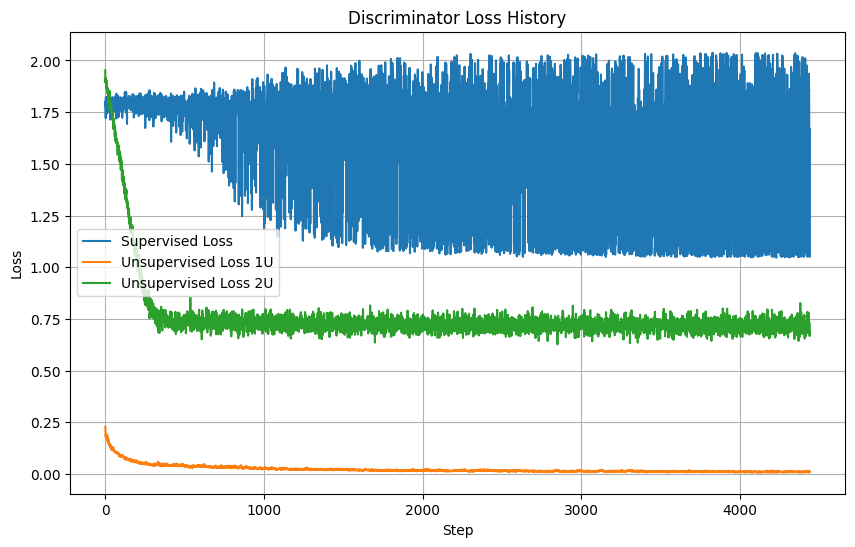

In [ ]:
model_name = "bert-base-cased"
generator1 = G1()
discriminator = Discriminator()

# Load pre-trained BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained(model_name)
bert_model = BertModel.from_pretrained(model_name)

# Move to GPU
if torch.cuda.is_available():
  generator1.cuda()
  discriminator.cuda()
  bert_model.cuda()

# Create an instance of your custom dataset
train_dataset = CustomDataset(jsonl_train_path, tokenizer, max_length=512)
dev_dataset = CustomDataset(jsonl_dev_path, tokenizer, max_length=512)

# Create a DataLoader
batch_size_train = 16
batch_size_dev = 16
dataloader_train = DataLoader(train_dataset, batch_size=batch_size_train, shuffle=True)
dataloader_dev = DataLoader(dev_dataset, batch_size=batch_size_dev, shuffle=True)


#-------------------------------------------------------------------------------
#models parameters
d_vars = [v for v in discriminator.parameters()]
g_vars = [v for v in generator1.parameters()]
bert_vars = [i for i in bert_model.parameters()]
d_vars = bert_vars + d_vars

#optimizer
dis_optimizer = torch.optim.AdamW(d_vars, lr=5e-6)
gen_optimizer = torch.optim.AdamW(g_vars, lr=5e-6)
bert_optimizer = torch.optim.AdamW(bert_vars, lr=5e-6)


num_train_epochs = 1
epsilon = 1e-8
training_stats = []
percentage_dataset = 10
d_loss_hist = [[], [], []]


for epoch_i in range(0, num_train_epochs):
    # Perform one full pass over the training set.
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, num_train_epochs))
    print('Training...')

    # Reset the total loss for this epoch.
    tr_g_loss = 0
    tr_d_loss = 0

    # Put the model into training mode.
    bert_model.train()
    generator1.train()
    discriminator.train()

    # For each batch of training data...
    for step, batch in enumerate(dataloader_train):
        # if step*batch_size_train > len(dataloader_train)*percentage_dataset:
        #   break
        b_input_id = batch['id'].to(device)
        b_input_label = batch['label'].to(device)
        b_input_ids = batch['input_ids'].to(device)
        b_input_AM = batch['attention_mask'].to(device)

        outputs = bert_model(input_ids=b_input_ids, attention_mask=b_input_AM)
        pooler_output = outputs.pooler_output  # Get pooler output

        real_batch_size = b_input_ids.shape[0]

        fake_batch_size = real_batch_size
        noise = torch.randn(fake_batch_size, 100, device=device)

        gen_rep = generator1(noise)


        disciminator_input = torch.cat([pooler_output, gen_rep], dim=0)

        features, probs, logits = discriminator(disciminator_input)

        # Finally, we separate the discriminator's output for the real and fake
        features_list = torch.split(features, real_batch_size)
        real_features = features_list[0]
        fake_features = features_list[1]

        probs_list = torch.split(probs, real_batch_size)
        real_probs = probs_list[0]
        fake_probs = probs_list[1]

        logits_list = torch.split(logits, real_batch_size)
        real_logits = probs_list[0]
        fake_logits = probs_list[1]
        #---------------------------------
        #  LOSS evaluation
        #---------------------------------
        # Generator's LOSS estimation
        g_loss_d = -1 * torch.mean(torch.log(1 - fake_probs[:,-1] + epsilon))
        g_feat_reg = torch.mean(torch.pow(torch.mean(real_features, dim=0) - torch.mean(fake_features, dim=0), 2))
        beta = 1
        g_loss = (2-beta)*g_loss_d + beta*g_feat_reg



        # Disciminator's LOSS estimation
        logits = real_logits[:,0:-1]
        log_probs = F.log_softmax(logits, dim=-1)
        # The discriminator provides an output for labeled and unlabeled real data
        # so the loss evaluated for unlabeled data is ignored (masked)
        label2one_hot = torch.nn.functional.one_hot(b_input_label, 6)
        per_example_loss = -torch.sum(label2one_hot * log_probs, dim=-1)
        # -------- Mask Generation----------
        num_elements_annotated = 1
        anotated_percent = num_elements_annotated / batch_size_train # 1/16 ~= 6.25
        mask = torch.zeros_like(per_example_loss, dtype=torch.bool, device=device)
        indices_to_mask = torch.randperm(len(per_example_loss))[:num_elements_annotated].to(device)
        mask[indices_to_mask] = True
        # mask input
        per_example_loss = torch.masked_select(per_example_loss, mask)
        labeled_example_count = per_example_loss.type(torch.float32).numel()
        # supervised loss of discriminator
        D_L_Supervised = torch.div(torch.sum(per_example_loss.to(device)), labeled_example_count)
        # unsupervised loss of discriminator
        D_L_unsupervised1U = -1 * torch.mean(torch.log(1 - real_probs[:, -1] + epsilon))
        D_L_unsupervised2U = -1 * torch.mean(torch.log(fake_probs[:, -1] + epsilon))
        d_loss = D_L_Supervised + D_L_unsupervised1U + D_L_unsupervised2U

        d_loss_hist[0].append(D_L_Supervised.item())
        d_loss_hist[1].append(D_L_unsupervised1U.item())
        d_loss_hist[2].append(D_L_unsupervised2U.item())
        #---------------------------------
        #  OPTIMIZATION
        #---------------------------------
        gen_optimizer.zero_grad()
        dis_optimizer.zero_grad()
        bert_optimizer.zero_grad()


        # Calculate weigth updates
        # retain_graph=True is required since the underlying graph will be deleted after backward
        g_loss.backward(retain_graph=True)
        d_loss.backward()


        # Apply modifications
        gen_optimizer.step()
        dis_optimizer.step()


        # Save the losses to print them later
        tr_g_loss += g_loss.item()
        tr_d_loss += d_loss.item()


    # Calculate the average loss over all of the batches.
    avg_train_loss_g = tr_g_loss / len(dataloader_train)
    avg_train_loss_d = tr_d_loss / len(dataloader_train)


    print("  Average training loss generetor: {0:.3f}".format(avg_train_loss_g))
    print("  Average training loss discriminator: {0:.3f}".format(avg_train_loss_d))

    # ========================================
    #     TEST ON THE EVALUATION DATASET
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our test set.
    print("")
    print("Running Test...")

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    bert_model.eval() #maybe redundant
    discriminator.eval()
    generator1.eval()

    # Tracking variables
    total_test_accuracy = 0

    total_test_loss = 0
    nb_test_steps = 0

    all_preds = []
    all_labels_ids = []

    #loss
    nll_loss = torch.nn.CrossEntropyLoss(ignore_index=-1)


    # Evaluate data for one epoch
    for batch in dataloader_dev:
        # Unpack this training batch from our dataloader.
        b_input_id = batch['id'].to(device)
        b_input_label = batch['label'].to(device)
        b_input_ids = batch['input_ids'].to(device)
        b_input_AM = batch['attention_mask'].to(device)

        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():
            model_outputs = bert_model(b_input_ids, attention_mask=b_input_AM)
            pooler_output = model_outputs.pooler_output
            _, probs, logits = discriminator(pooler_output)
            ###log_probs = F.log_softmax(probs[:,1:], dim=-1)
            filtered_logits = logits[:,0:-1]
            # Accumulate the test loss.
            total_test_loss += nll_loss(filtered_logits, b_input_label)

        # Accumulate the predictions and the input labels
        _, preds = torch.max(filtered_logits, 1)
        all_preds += preds.detach().cpu()
        all_labels_ids += b_input_label.detach().cpu()

    # Report the final accuracy for this validation run.
    all_preds = torch.stack(all_preds).numpy()
    all_labels_ids = torch.stack(all_labels_ids).numpy()
    test_accuracy = np.sum(all_preds == all_labels_ids) / len(all_preds)
    print("  Accuracy: {0:.3f}".format(test_accuracy))

    # Calculate the average loss over all of the batches.
    avg_test_loss = total_test_loss / len(dataloader_dev)
    avg_test_loss = avg_test_loss.item()

    print("  Test Loss: {0:.3f}".format(avg_test_loss))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss generator': avg_train_loss_g,
            'Training Loss discriminator': avg_train_loss_d,
            'Valid. Loss': avg_test_loss,
            'Valid. Accur.': test_accuracy,
        }
    )
#-------------------------------------------------------------------------------
# d_loss_hist contains three lists: D_L_Supervised, D_L_unsupervised1U, D_L_unsupervised2U
D_L_Supervised, D_L_unsupervised1U, D_L_unsupervised2U = d_loss_hist

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(D_L_Supervised, label='Supervised Loss')
plt.plot(D_L_unsupervised1U, label='Unsupervised Loss 1U')
plt.plot(D_L_unsupervised2U, label='Unsupervised Loss 2U')
plt.title('Discriminator Loss History')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


# Generator2 Results:

Create Bag of Words:

The secend generator selects some words from all words in trianing dataset and after tokenizing, give them into a Bert model to create noisy data.

In [7]:
from collections import Counter
import random

def collect_all_words(jsonl_file_path):
    all_words = []

    # Open and read the JSON Lines file
    with jsonlines.open(jsonl_file_path, 'r') as reader:
        for obj in reader:
            # Split the text into words and extend the all_words list with these words
            all_words.extend(obj['text'].split())

    return all_words

# Usage
# jsonl_file_path = '/content/dataset_folder/subtaskB_train.jsonl'
all_words = collect_all_words(jsonl_train_path)

In [8]:
model_name = "bert-base-cased"
generator2 = G2()
discriminator = Discriminator()

# Load pre-trained BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained(model_name)
bert_model = BertModel.from_pretrained(model_name)

# Move to GPU
if torch.cuda.is_available():
  generator2.cuda()
  discriminator.cuda()
  bert_model.cuda()

# Create an instance of your custom dataset
train_dataset = CustomDataset(jsonl_train_path, tokenizer, max_length=512)
dev_dataset = CustomDataset(jsonl_dev_path, tokenizer, max_length=512)

# Create a DataLoader
batch_size_train = 16
batch_size_dev = 16
dataloader_train = DataLoader(train_dataset, batch_size=batch_size_train, shuffle=True)
dataloader_dev = DataLoader(dev_dataset, batch_size=batch_size_dev, shuffle=True)

Annotation=50%

In [ ]:
#models parameters
d_vars = [v for v in discriminator.parameters()]
g_vars = [v for v in generator2.parameters()]
bert_vars = [i for i in bert_model.parameters()]
d_vars = bert_vars + d_vars

#optimizer
dis_optimizer = torch.optim.AdamW(d_vars, lr=5e-6)
gen_optimizer = torch.optim.AdamW(g_vars, lr=5e-5)
bert_optimizer = torch.optim.AdamW(bert_vars, lr=5e-6)

# Define the size of your sample
sample_size = 100
num_train_epochs = 1
epsilon = 1e-8
training_stats = []
# percentage_dataset = 10

for epoch_i in range(0, num_train_epochs):
    # Perform one full pass over the training set.
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, num_train_epochs))
    print('Training...')

    # Reset the total loss for this epoch.
    tr_g_loss = 0
    tr_d_loss = 0

    # Put the model into training mode.
    bert_model.train()
    generator2.train()
    discriminator.train()

    # For each batch of training data...
    for step, batch in enumerate(dataloader_train):
        # if step*100 > len(dataloader_train)*percentage_dataset:
        #   break
        b_input_id = batch['id'].to(device)
        b_input_label = batch['label'].to(device)
        b_input_ids = batch['input_ids'].to(device)
        b_input_AM = batch['attention_mask'].to(device)

        outputs = bert_model(input_ids=b_input_ids, attention_mask=b_input_AM)
        pooler_output = outputs.pooler_output  # Get pooler output

        real_batch_size = b_input_ids.shape[0]

        fake_batch_size = real_batch_size

        # noise = torch.randn(fake_batch_size, 100, device=device)

        # gen_rep = generator1(noise)
        # Create the random sample from the Bag of Words
        X = random.choices(all_words, k=sample_size)
        X_string = " ".join(X)
        # gen_rep = generator2(X_string).to(device)
        inputs = generator2.tokenizer(X_string, return_tensors='pt', padding=True, truncation=True)
        inputs = {k: v.to(device) for k, v in inputs.items()}  # Move input tensors to the correct device

        gen_rep = generator2(inputs)


        disciminator_input = torch.cat([pooler_output, gen_rep], dim=0)

        features, probs, logits = discriminator(disciminator_input)

        # Finally, we separate the discriminator's output for the real and fake
        features_list = torch.split(features, real_batch_size)
        real_features = features_list[0]
        fake_features = features_list[1]

        probs_list = torch.split(probs, real_batch_size)
        real_probs = probs_list[0]
        fake_probs = probs_list[1]

        logits_list = torch.split(logits, real_batch_size)
        real_logits = probs_list[0]
        fake_logits = probs_list[1]
        #---------------------------------
        #  LOSS evaluation
        #---------------------------------
        # Generator's LOSS estimation
        g_loss_d = -1 * torch.mean(torch.log(1 - fake_probs[:,-1] + epsilon))
        g_feat_reg = torch.mean(torch.pow(torch.mean(real_features, dim=0) - torch.mean(fake_features, dim=0), 2))
        g_loss = g_loss_d + g_feat_reg



        # Disciminator's LOSS estimation
        logits = real_logits[:,0:-1]
        log_probs = F.log_softmax(logits, dim=-1)
        # The discriminator provides an output for labeled and unlabeled real data
        # so the loss evaluated for unlabeled data is ignored (masked)
        label2one_hot = torch.nn.functional.one_hot(b_input_label, 6)
        per_example_loss = -torch.sum(label2one_hot * log_probs, dim=-1)
        # -------- Mask Generation----------
        num_elements_to_mask = 8
        mask = torch.zeros_like(per_example_loss, dtype=torch.bool, device=device)
        indices_to_mask = torch.randperm(len(per_example_loss))[:num_elements_to_mask].to(device)
        mask[indices_to_mask] = True
        # mask input
        per_example_loss = torch.masked_select(per_example_loss, mask)
        labeled_example_count = per_example_loss.type(torch.float32).numel()
        # supervised loss of discriminator
        D_L_Supervised = torch.div(torch.sum(per_example_loss.to(device)), labeled_example_count)
        # unsupervised loss of discriminator
        D_L_unsupervised1U = -1 * torch.mean(torch.log(1 - real_probs[:, -1] + epsilon))
        D_L_unsupervised2U = -1 * torch.mean(torch.log(fake_probs[:, -1] + epsilon))
        d_loss = D_L_Supervised + D_L_unsupervised1U + D_L_unsupervised2U


        #---------------------------------
        #  OPTIMIZATION
        #---------------------------------
        gen_optimizer.zero_grad()
        dis_optimizer.zero_grad()
        bert_optimizer.zero_grad()


        # Calculate weigth updates
        # retain_graph=True is required since the underlying graph will be deleted after backward
        g_loss.backward(retain_graph=True)
        d_loss.backward()


        # Apply modifications
        gen_optimizer.step()
        dis_optimizer.step()


        # Save the losses to print them later
        tr_g_loss += g_loss.item()
        tr_d_loss += d_loss.item()


    # Calculate the average loss over all of the batches.
    avg_train_loss_g = tr_g_loss / len(dataloader_train)
    avg_train_loss_d = tr_d_loss / len(dataloader_train)


    print("  Average training loss generetor: {0:.3f}".format(avg_train_loss_g))
    print("  Average training loss discriminator: {0:.3f}".format(avg_train_loss_d))

    # ========================================
    #     TEST ON THE EVALUATION DATASET
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our test set.
    print("")
    print("Running Test...")

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    bert_model.eval() #maybe redundant
    discriminator.eval()
    generator2.eval()

    # Tracking variables
    total_test_accuracy = 0

    total_test_loss = 0
    nb_test_steps = 0

    all_preds = []
    all_labels_ids = []

    #loss
    nll_loss = torch.nn.CrossEntropyLoss(ignore_index=-1)


    # Evaluate data for one epoch
    for batch in dataloader_dev:
        # Unpack this training batch from our dataloader.
        b_input_id = batch['id'].to(device)
        b_input_label = batch['label'].to(device)
        b_input_ids = batch['input_ids'].to(device)
        b_input_AM = batch['attention_mask'].to(device)

        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():
            model_outputs = bert_model(b_input_ids, attention_mask=b_input_AM)
            pooler_output = model_outputs.pooler_output
            _, probs, logits = discriminator(pooler_output)
            ###log_probs = F.log_softmax(probs[:,1:], dim=-1)
            filtered_logits = logits[:,0:-1]
            # Accumulate the test loss.
            total_test_loss += nll_loss(filtered_logits, b_input_label)

        # Accumulate the predictions and the input labels
        _, preds = torch.max(filtered_logits, 1)
        all_preds += preds.detach().cpu()
        all_labels_ids += b_input_label.detach().cpu()

    # Report the final accuracy for this validation run.
    all_preds = torch.stack(all_preds).numpy()
    all_labels_ids = torch.stack(all_labels_ids).numpy()
    test_accuracy = np.sum(all_preds == all_labels_ids) / len(all_preds)
    print("  Accuracy: {0:.3f}".format(test_accuracy))

    # Calculate the average loss over all of the batches.
    avg_test_loss = total_test_loss / len(dataloader_dev)
    avg_test_loss = avg_test_loss.item()

    print("  Test Loss: {0:.3f}".format(avg_test_loss))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss generatorf': avg_train_loss_g,
            'Training Loss discriminator': avg_train_loss_d,
            'Valid. Loss': avg_test_loss,
            'Valid. Accur.': test_accuracy,
        }
    )




======== Epoch 1 / 1 ========

Training...

  Average training loss generetor: 0.733

  Average training loss discriminator: 2.142



Running Test...

  Accuracy: 0.578

  Test Loss: 2.070


Annotation=12.5%

In [ ]:
model_name = "bert-base-cased"
generator2 = G2()
discriminator = Discriminator()

# Load pre-trained BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained(model_name)
bert_model = BertModel.from_pretrained(model_name)

# Move to GPU
if torch.cuda.is_available():
  generator2.cuda()
  discriminator.cuda()
  bert_model.cuda()

# Create an instance of your custom dataset
train_dataset = CustomDataset(jsonl_train_path, tokenizer, max_length=512)
dev_dataset = CustomDataset(jsonl_dev_path, tokenizer, max_length=512)

# Create a DataLoader
batch_size_train = 16
batch_size_dev = 16
dataloader_train = DataLoader(train_dataset, batch_size=batch_size_train, shuffle=True)
dataloader_dev = DataLoader(dev_dataset, batch_size=batch_size_dev, shuffle=True)

#-------------------------------------------------------------------------------
#models parameters
d_vars = [v for v in discriminator.parameters()]
g_vars = [v for v in generator2.parameters()]
bert_vars = [i for i in bert_model.parameters()]
d_vars = bert_vars + d_vars

#optimizer
dis_optimizer = torch.optim.AdamW(d_vars, lr=5e-6)
gen_optimizer = torch.optim.AdamW(g_vars, lr=5e-5)
# bert_optimizer = torch.optim.AdamW(bert_vars, lr=5e-6)

# Define the size of your sample
sample_size = 100
num_train_epochs = 1
epsilon = 1e-8
training_stats = []
percentage_dataset = 10

for epoch_i in range(0, num_train_epochs):
    # Perform one full pass over the training set.
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, num_train_epochs))
    print('Training...')

    # Reset the total loss for this epoch.
    tr_g_loss = 0
    tr_d_loss = 0

    # Put the model into training mode.
    bert_model.train()
    generator2.train()
    discriminator.train()

    # For each batch of training data...
    for step, batch in enumerate(dataloader_train):
        # if step*100 > len(dataloader_train)*percentage_dataset:
        #   break
        b_input_id = batch['id'].to(device)
        b_input_label = batch['label'].to(device)
        b_input_ids = batch['input_ids'].to(device)
        b_input_AM = batch['attention_mask'].to(device)

        outputs = bert_model(input_ids=b_input_ids, attention_mask=b_input_AM)
        pooler_output = outputs.pooler_output  # Get pooler output

        real_batch_size = b_input_ids.shape[0]

        fake_batch_size = real_batch_size

        # noise = torch.randn(fake_batch_size, 100, device=device)

        # gen_rep = generator1(noise)
        # Create the random sample from the Bag of Words
        X = random.choices(all_words, k=sample_size)
        X_string = " ".join(X)
        # gen_rep = generator2(X_string).to(device)
        inputs = generator2.tokenizer(X_string, return_tensors='pt', padding=True, truncation=True)
        inputs = {k: v.to(device) for k, v in inputs.items()}  # Move input tensors to the correct device

        gen_rep = generator2(inputs)


        disciminator_input = torch.cat([pooler_output, gen_rep], dim=0)

        features, probs, logits = discriminator(disciminator_input)

        # Finally, we separate the discriminator's output for the real and fake
        features_list = torch.split(features, real_batch_size)
        real_features = features_list[0]
        fake_features = features_list[1]

        probs_list = torch.split(probs, real_batch_size)
        real_probs = probs_list[0]
        fake_probs = probs_list[1]

        logits_list = torch.split(logits, real_batch_size)
        real_logits = probs_list[0]
        fake_logits = probs_list[1]
        #---------------------------------
        #  LOSS evaluation
        #---------------------------------
        # Generator's LOSS estimation
        g_loss_d = -1 * torch.mean(torch.log(1 - fake_probs[:,-1] + epsilon))
        g_feat_reg = torch.mean(torch.pow(torch.mean(real_features, dim=0) - torch.mean(fake_features, dim=0), 2))
        g_loss = g_loss_d + g_feat_reg



        # Disciminator's LOSS estimation
        logits = real_logits[:,0:-1]
        log_probs = F.log_softmax(logits, dim=-1)
        # The discriminator provides an output for labeled and unlabeled real data
        # so the loss evaluated for unlabeled data is ignored (masked)
        label2one_hot = torch.nn.functional.one_hot(b_input_label, 6)
        per_example_loss = -torch.sum(label2one_hot * log_probs, dim=-1)
        # -------- Mask Generation----------
        num_elements_to_mask = 2
        mask = torch.zeros_like(per_example_loss, dtype=torch.bool, device=device)
        indices_to_mask = torch.randperm(len(per_example_loss))[:num_elements_to_mask].to(device)
        mask[indices_to_mask] = True
        # mask input
        per_example_loss = torch.masked_select(per_example_loss, mask)
        labeled_example_count = per_example_loss.type(torch.float32).numel()
        # supervised loss of discriminator
        D_L_Supervised = torch.div(torch.sum(per_example_loss.to(device)), labeled_example_count)
        # unsupervised loss of discriminator
        D_L_unsupervised1U = -1 * torch.mean(torch.log(1 - real_probs[:, -1] + epsilon))
        D_L_unsupervised2U = -1 * torch.mean(torch.log(fake_probs[:, -1] + epsilon))
        d_loss = D_L_Supervised + D_L_unsupervised1U + D_L_unsupervised2U


        #---------------------------------
        #  OPTIMIZATION
        #---------------------------------
        gen_optimizer.zero_grad()
        dis_optimizer.zero_grad()
        # bert_optimizer.zero_grad()


        # Calculate weigth updates
        # retain_graph=True is required since the underlying graph will be deleted after backward
        g_loss.backward(retain_graph=True)
        d_loss.backward()


        # Apply modifications
        gen_optimizer.step()
        dis_optimizer.step()


        # Save the losses to print them later
        tr_g_loss += g_loss.item()
        tr_d_loss += d_loss.item()


    # Calculate the average loss over all of the batches.
    avg_train_loss_g = tr_g_loss / len(dataloader_train)
    avg_train_loss_d = tr_d_loss / len(dataloader_train)


    print("  Average training loss generetor: {0:.3f}".format(avg_train_loss_g))
    print("  Average training loss discriminator: {0:.3f}".format(avg_train_loss_d))

    # ========================================
    #     TEST ON THE EVALUATION DATASET
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our test set.
    print("")
    print("Running Test...")

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    bert_model.eval() #maybe redundant
    discriminator.eval()
    generator2.eval()

    # Tracking variables
    total_test_accuracy = 0

    total_test_loss = 0
    nb_test_steps = 0

    all_preds = []
    all_labels_ids = []

    #loss
    nll_loss = torch.nn.CrossEntropyLoss(ignore_index=-1)


    # Evaluate data for one epoch
    for batch in dataloader_dev:
        # Unpack this training batch from our dataloader.
        b_input_id = batch['id'].to(device)
        b_input_label = batch['label'].to(device)
        b_input_ids = batch['input_ids'].to(device)
        b_input_AM = batch['attention_mask'].to(device)

        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():
            model_outputs = bert_model(b_input_ids, attention_mask=b_input_AM)
            pooler_output = model_outputs.pooler_output
            _, probs, logits = discriminator(pooler_output)
            ###log_probs = F.log_softmax(probs[:,1:], dim=-1)
            filtered_logits = logits[:,0:-1]
            # Accumulate the test loss.
            total_test_loss += nll_loss(filtered_logits, b_input_label)

        # Accumulate the predictions and the input labels
        _, preds = torch.max(filtered_logits, 1)
        all_preds += preds.detach().cpu()
        all_labels_ids += b_input_label.detach().cpu()

    # Report the final accuracy for this validation run.
    all_preds = torch.stack(all_preds).numpy()
    all_labels_ids = torch.stack(all_labels_ids).numpy()
    test_accuracy = np.sum(all_preds == all_labels_ids) / len(all_preds)
    print("  Accuracy: {0:.3f}".format(test_accuracy))

    # Calculate the average loss over all of the batches.
    avg_test_loss = total_test_loss / len(dataloader_dev)
    avg_test_loss = avg_test_loss.item()

    print("  Test Loss: {0:.3f}".format(avg_test_loss))


======== Epoch 1 / 1 ========
Training...
  Average training loss generetor: 0.729
  Average training loss discriminator: 2.295

Running Test...
  Accuracy: 0.526
  Test Loss: 1.742


Annotation=6.25%

In [ ]:
model_name = "bert-base-cased"
generator2 = G2()
discriminator = Discriminator()

# Load pre-trained BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained(model_name)
bert_model = BertModel.from_pretrained(model_name)

# Move to GPU
if torch.cuda.is_available():
  generator2.cuda()
  discriminator.cuda()
  bert_model.cuda()

# Create an instance of your custom dataset
train_dataset = CustomDataset(jsonl_train_path, tokenizer, max_length=512)
dev_dataset = CustomDataset(jsonl_dev_path, tokenizer, max_length=512)

# Create a DataLoader
batch_size_train = 16
batch_size_dev = 16
dataloader_train = DataLoader(train_dataset, batch_size=batch_size_train, shuffle=True)
dataloader_dev = DataLoader(dev_dataset, batch_size=batch_size_dev, shuffle=True)

#-------------------------------------------------------------------------------
#models parameters
d_vars = [v for v in discriminator.parameters()]
g_vars = [v for v in generator2.parameters()]
bert_vars = [i for i in bert_model.parameters()]
d_vars = bert_vars + d_vars

#optimizer
dis_optimizer = torch.optim.AdamW(d_vars, lr=5e-6)
gen_optimizer = torch.optim.AdamW(g_vars, lr=5e-5)
# bert_optimizer = torch.optim.AdamW(bert_vars, lr=5e-6)

# Define the size of your sample
sample_size = 100
num_train_epochs = 1
epsilon = 1e-8
training_stats = []
percentage_dataset = 10

for epoch_i in range(0, num_train_epochs):
    # Perform one full pass over the training set.
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, num_train_epochs))
    print('Training...')

    # Reset the total loss for this epoch.
    tr_g_loss = 0
    tr_d_loss = 0

    # Put the model into training mode.
    bert_model.train()
    generator2.train()
    discriminator.train()

    # For each batch of training data...
    for step, batch in enumerate(dataloader_train):
        # if step*100 > len(dataloader_train)*percentage_dataset:
        #   break
        b_input_id = batch['id'].to(device)
        b_input_label = batch['label'].to(device)
        b_input_ids = batch['input_ids'].to(device)
        b_input_AM = batch['attention_mask'].to(device)

        outputs = bert_model(input_ids=b_input_ids, attention_mask=b_input_AM)
        pooler_output = outputs.pooler_output  # Get pooler output

        real_batch_size = b_input_ids.shape[0]

        fake_batch_size = real_batch_size

        # noise = torch.randn(fake_batch_size, 100, device=device)

        # gen_rep = generator1(noise)
        # Create the random sample from the Bag of Words
        X = random.choices(all_words, k=sample_size)
        X_string = " ".join(X)
        # gen_rep = generator2(X_string).to(device)
        inputs = generator2.tokenizer(X_string, return_tensors='pt', padding=True, truncation=True)
        inputs = {k: v.to(device) for k, v in inputs.items()}  # Move input tensors to the correct device

        gen_rep = generator2(inputs)


        disciminator_input = torch.cat([pooler_output, gen_rep], dim=0)

        features, probs, logits = discriminator(disciminator_input)

        # Finally, we separate the discriminator's output for the real and fake
        features_list = torch.split(features, real_batch_size)
        real_features = features_list[0]
        fake_features = features_list[1]

        probs_list = torch.split(probs, real_batch_size)
        real_probs = probs_list[0]
        fake_probs = probs_list[1]

        logits_list = torch.split(logits, real_batch_size)
        real_logits = probs_list[0]
        fake_logits = probs_list[1]
        #---------------------------------
        #  LOSS evaluation
        #---------------------------------
        # Generator's LOSS estimation
        g_loss_d = -1 * torch.mean(torch.log(1 - fake_probs[:,-1] + epsilon))
        g_feat_reg = torch.mean(torch.pow(torch.mean(real_features, dim=0) - torch.mean(fake_features, dim=0), 2))
        g_loss = g_loss_d + g_feat_reg



        # Disciminator's LOSS estimation
        logits = real_logits[:,0:-1]
        log_probs = F.log_softmax(logits, dim=-1)
        # The discriminator provides an output for labeled and unlabeled real data
        # so the loss evaluated for unlabeled data is ignored (masked)
        label2one_hot = torch.nn.functional.one_hot(b_input_label, 6)
        per_example_loss = -torch.sum(label2one_hot * log_probs, dim=-1)
        # -------- Mask Generation----------
        num_elements_to_mask = 1
        mask = torch.zeros_like(per_example_loss, dtype=torch.bool, device=device)
        indices_to_mask = torch.randperm(len(per_example_loss))[:num_elements_to_mask].to(device)
        mask[indices_to_mask] = True
        # mask input
        per_example_loss = torch.masked_select(per_example_loss, mask)
        labeled_example_count = per_example_loss.type(torch.float32).numel()
        # supervised loss of discriminator
        D_L_Supervised = torch.div(torch.sum(per_example_loss.to(device)), labeled_example_count)
        # unsupervised loss of discriminator
        D_L_unsupervised1U = -1 * torch.mean(torch.log(1 - real_probs[:, -1] + epsilon))
        D_L_unsupervised2U = -1 * torch.mean(torch.log(fake_probs[:, -1] + epsilon))
        d_loss = D_L_Supervised + D_L_unsupervised1U + D_L_unsupervised2U


        #---------------------------------
        #  OPTIMIZATION
        #---------------------------------
        gen_optimizer.zero_grad()
        dis_optimizer.zero_grad()
        #bert_optimizer.zero_grad()


        # Calculate weigth updates
        # retain_graph=True is required since the underlying graph will be deleted after backward
        g_loss.backward(retain_graph=True)
        d_loss.backward()


        # Apply modifications
        gen_optimizer.step()
        dis_optimizer.step()


        # Save the losses to print them later
        tr_g_loss += g_loss.item()
        tr_d_loss += d_loss.item()


    # Calculate the average loss over all of the batches.
    avg_train_loss_g = tr_g_loss / len(dataloader_train)
    avg_train_loss_d = tr_d_loss / len(dataloader_train)


    print("  Average training loss generetor: {0:.3f}".format(avg_train_loss_g))
    print("  Average training loss discriminator: {0:.3f}".format(avg_train_loss_d))

    # ========================================
    #     TEST ON THE EVALUATION DATASET
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our test set.
    print("")
    print("Running Test...")

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    bert_model.eval() #maybe redundant
    discriminator.eval()
    generator2.eval()

    # Tracking variables
    total_test_accuracy = 0

    total_test_loss = 0
    nb_test_steps = 0

    all_preds = []
    all_labels_ids = []

    #loss
    nll_loss = torch.nn.CrossEntropyLoss(ignore_index=-1)


    # Evaluate data for one epoch
    for batch in dataloader_dev:
        # Unpack this training batch from our dataloader.
        b_input_id = batch['id'].to(device)
        b_input_label = batch['label'].to(device)
        b_input_ids = batch['input_ids'].to(device)
        b_input_AM = batch['attention_mask'].to(device)

        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():
            model_outputs = bert_model(b_input_ids, attention_mask=b_input_AM)
            pooler_output = model_outputs.pooler_output
            _, probs, logits = discriminator(pooler_output)
            ###log_probs = F.log_softmax(probs[:,1:], dim=-1)
            filtered_logits = logits[:,0:-1]
            # Accumulate the test loss.
            total_test_loss += nll_loss(filtered_logits, b_input_label)

        # Accumulate the predictions and the input labels
        _, preds = torch.max(filtered_logits, 1)
        all_preds += preds.detach().cpu()
        all_labels_ids += b_input_label.detach().cpu()

    # Report the final accuracy for this validation run.
    all_preds = torch.stack(all_preds).numpy()
    all_labels_ids = torch.stack(all_labels_ids).numpy()
    test_accuracy = np.sum(all_preds == all_labels_ids) / len(all_preds)
    print("  Accuracy: {0:.3f}".format(test_accuracy))

    # Calculate the average loss over all of the batches.
    avg_test_loss = total_test_loss / len(dataloader_dev)
    avg_test_loss = avg_test_loss.item()

    print("  Test Loss: {0:.3f}".format(avg_test_loss))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss generatorf': avg_train_loss_g,
            'Training Loss discriminator': avg_train_loss_d,
            'Valid. Loss': avg_test_loss,
            'Valid. Accur.': test_accuracy,
        }
    )



======== Epoch 1 / 1 ========
Training...
  Average training loss generetor: 0.727
  Average training loss discriminator: 2.378

Running Test...
  Accuracy: 0.421
  Test Loss: 1.766


# Compare G1 and G2:


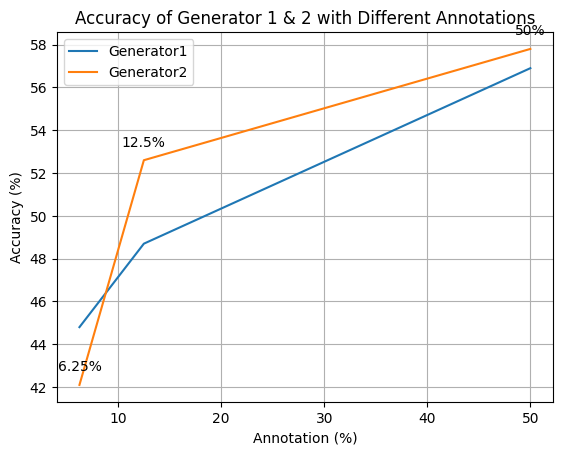

In [1]:
import matplotlib.pyplot as plt

g2_accuracy = [57.8, 52.6, 42.1]
g1_accuracy = [56.9, 48.7, 44.8]
annotation = [50, 12.5, 6.25]

# Plotting
plt.plot(annotation, g1_accuracy, label='Generator1')
plt.plot(annotation, g2_accuracy, label='Generator2')

# Adding annotations
for i, txt in enumerate(annotation):
    plt.annotate(f'{txt}%', (annotation[i], g2_accuracy[i]), textcoords="offset points", xytext=(0,10), ha='center')

plt.xlabel('Annotation (%)')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy of Generator 1 & 2 with Different Annotations')
plt.legend()
plt.grid(True)

plt.show()